In [54]:
from prefect import Flow,task, Task,unmapped, Parameter
import sys
import os
from os.path import join, splitext
import matplotlib.pyplot as plt
from pandas import to_datetime
import xarray as xr
from scipy import ndimage, integrate
sys.path.insert(0, '/home/david/Institut/data-analysis/rydanalysis/')
from rydanalysis import *
from lmfit.models import PowerLawModel, ConstantModel, Model

In [2]:
import plotly.graph_objects as go


import plotly
plotly.tools.set_credentials_file(username='dgrimshandl', api_key='••••••••••')

In [3]:
analysis_root= '/home/david/Institut/analysis'
seq_path = "October/22/OmegaPScanFinalFinalFinal"
data_root ='/home/david/Institut/2019_IEI_new'

analysis_dir = Directory(join(analysis_root,seq_path))
netcdf_suffix = '.nc'

noise_analysis_dir = Directory(join(analysis_dir.path,'noise_analysis'))

In [4]:
a = noise_analysis_dir['image_03'+netcdf_suffix]

In [5]:
a['image_03_projection']

<xarray.DataArray 'image_03_projection' (shot: 3411, x: 80, y: 370)>
[100965600 values with dtype=float64]
Dimensions without coordinates: shot, x, y

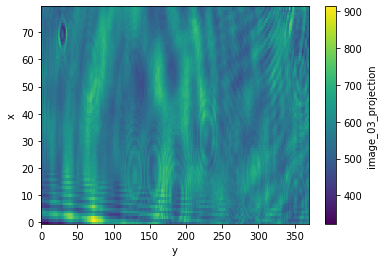

In [6]:
a['image_03_projection'][100].plot()

In [100]:
d_flat = xr.merge((a['image_03_projection'][:100].stack(point=('shot','x','y'))-200,a['image_03_residual'][:100].stack(point=('shot','x','y'))))

d_flat = d_flat.groupby_bins('image_03_projection',bins=100)
mean_pix = d_flat.mean()
std_pix = d_flat.std()

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

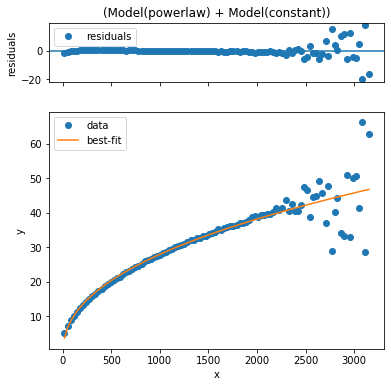

In [101]:
power_law = PowerLawModel()+ConstantModel()

fit = power_law.fit(std_pix['image_03_residual'],x=mean_pix['image_03_projection'])
fit.plot()

In [107]:
def noise_func(x,sig_read=4, A=0):
    return A*np.sqrt( x + sig_read**2)

In [108]:
noise_model=Model(noise_func)

In [114]:
fit =noise_model.fit(std_pix['image_03_residual'],x=mean_pix['image_03_projection'],weights=1/mean_pix['image_03_projection'])

In [115]:
fig = go.FigureWidget()

fig.add_scattergl(x=mean_pix['image_03_projection'],y=std_pix['image_03_residual'],mode='lines+markers')#,error_x={'array':std_pix['image_03_projection']})
fig.update_layout(xaxis_type="log", 
                  yaxis_type="log")
fig.add_scattergl(x=mean_pix['image_03_projection'],y=fit.best_fit)

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'type': 'scattergl',
              'uid': …

In [116]:
fit

In [113]:
0.866**2

0.749956

In [ ]:
plt.plot(a['image_03_projection'])

In [8]:
std_shot = ref.std(dim=['x','y'])
mean_shot = ref.mean(dim=['x','y'])

In [9]:
std = ref.groupby('pABSx').std(dim='shot')

In [10]:
std_seq = ref.std(dim='shot')
mean_seq = ref.mean(dim='shot')

In [11]:
std_p = ref.groupby('pABSx').std('shot')
mean_p = ref.groupby('pABSx').mean('shot')

In [12]:
intens = ref.mean(('x','y'))
intens_mean = intens.groupby('pABSx').mean('shot')
intens_std = intens.groupby('pABSx').std('shot')

In [50]:
bg = dark.mean()

In [ ]:
fig = go.FigureWidget()

fig.add_scattergl(x=mean_shot,y=std_shot,mode='markers');
fig.add_scattergl(x=mean_shot,y=std_shot,mode='markers');
fig.add_scattergl(x=mean_shot,y=std_shot,mode='markers');


In [47]:
fhist = go.FigureWidget()
fhist.add_histogram(x=intens,nbinsx=400)
fhist.update_xaxes(title_text = 'accumulated intensity [counts/pixel]')
fhist.update_yaxes(title_text = '# shots')

FigureWidget({
    'data': [{'nbinsx': 400,
              'type': 'histogram',
              'uid': '4ebff5bd-…

In [49]:
fig2 = go.FigureWidget()

fig2.add_scattergl(x=intens_mean-bg,y=intens_std,mode='markers')
fig2.update_xaxes(title_text="mean accumulated intensity [counts/pixel]");
fig2.update_yaxes(title_text="standard deviation [counts/pixel]")

FigureWidget({
    'data': [{'mode': 'markers',
              'type': 'scattergl',
              'uid': 'f9414…

In [66]:
fig.update_layout(xaxis_type="log", 
                  yaxis_type="log")
fig.update_xaxes(title_text="mean intensity [counts]");
fig.update_yaxes(title_text="standard deviation [counts]");

In [65]:
fig.data[0].y= std_p[:,52,185]
fig.data[0].x= mean_p[:,52,185]-bg
fig.data[0].name='single pixel'

In [63]:
fig.data[1].x= np.linspace(fig.data[2].x.min(),fig.data[2].x.max(),10)
fig.data[1].y= np.sqrt(np.linspace(max(fig.data[2].x.min(),0),fig.data[2].x.max(),10))
fig.data[1].mode='lines'
fig.data[1].name='$\sqrt{}$'

In [64]:
#fig.add_scatter(x=std_p[:,52,185],y=std_p[:,52,185])
fig.data[2].x=mean_p.mean(('x','y'))-bg
fig.data[2].y=std_p.mean(('x','y'))
fig.data[2].error_y=dict(array=std_p.std(('x','y')).values)
fig.data[2].mode='lines+markers'
fig.data[2].name='average over all pixels'
fig

FigureWidget({
    'data': [{'mode': 'markers',
              'type': 'scattergl',
              'uid': '1ddce…